Bibliothèques importées

 CHARGEMENT DES DONNEES
Donnees chargees : 1831 matchs

Apercu des donnees :
   Shape : (1831, 69)
   Colonnes : ['Date', 'HomeTeam', 'AwayTeam', 'HomeGoals', 'AwayGoals', 'FullTimeResult', 'HT_HomeGoals', 'HT_AwayGoals', 'HalfTimeResult', 'Referee']...

2. PREPARATION DES FEATURES ET TARGET
Features selectionnees (10) :
    1. HomeGoals
    2. AwayGoals
    3. HT_HomeGoals
    4. HT_AwayGoals
    5. HomeShots
    6. AwayShots
    7. HomeShotsTarget
    8. AwayShotsTarget
    9. HomeFouls
   10. AwayFouls

Target originale (ResultCode) :
   Classes : [-1, 0, 1]
   Distribution :
     - Exterieur  :  550 (30.0%)
     - Nul        :  445 (24.3%)
     - Domicile   :  836 (45.7%)

Target encodee (ResultCode_encoded) :
   Classes : [0, 1, 2]

3. SPLIT DES DONNEES
Repartition :
   Entrainement : 1464 matchs
   Test        : 367 matchs
   Ratio       : 80.0% / 20.0%

4. NORMALISATION
Scaler sauvegarde

5. DEFINITION DES MODELES
XGBoost ajoute

Modeles a entrainer (3) 

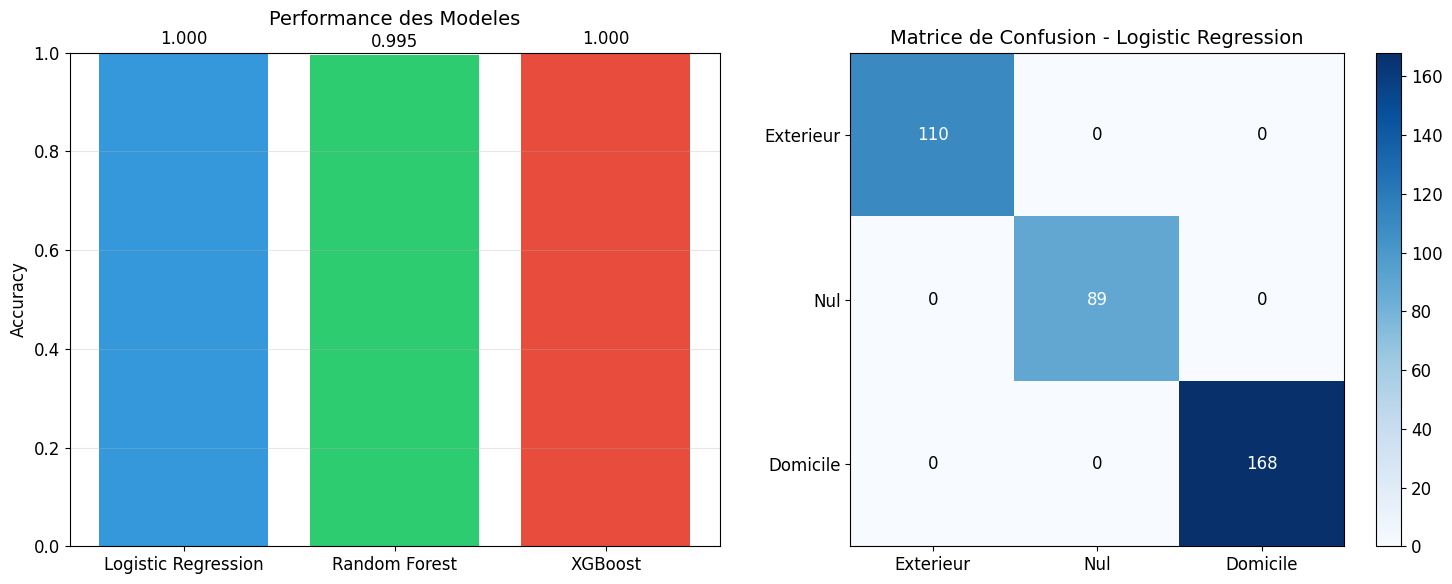


9. ANALYSE DETAILLEE

MEILLEUR MODELE : Logistic Regression
   Accuracy : 1.000

COMPARAISON :
   Meilleur modele  : 1.000
   Baseline (majorite) : 0.458
   Amelioration   : +54.2%

10. SAUVEGARDE FINALE
Resultats sauvegardes : ../models/model_performances.csv
Liste des features sauvegardee
Rapport JSON sauvegarde

 RESUME DU PROJET

DONNEES :
   Total matchs     : 1831
   Features utilisees : 10
   Distribution resultats :
     - Exterieur  :  550 (30.0%)
     - Nul        :  445 (24.3%)
     - Domicile   :  836 (45.7%)

PERFORMANCES :
   - Logistic Regression  : 1.000
   - Random Forest        : 0.995
   - XGBoost              : 1.000

CONCLUSION :
   Meilleur modele : Logistic Regression
   Accuracy        : 1.000
   Gain vs baseline : +54.2%

FICHIERS GENERES :
   Modeles : models/*.pkl
   Scaler  : models/scaler.pkl
   Resultats : models/model_performances.csv
   Rapport  : models/training_report.json
   Graphique : visuals/model_results.png

 ENTRAINEMENT REUSSI !


In [6]:
# 03 - Modèles de Machine Learning
# Version corrigée pour XGBoost

# Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import warnings
import joblib
import os
warnings.filterwarnings('ignore')

# Configuration
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Bibliothèques importées")

# %%
# 1. Chargement des données
print("\n" + "="*70)
print(" CHARGEMENT DES DONNEES")
print("="*70)

# Essayer de charger les données
try:
    df = pd.read_csv("../data/processed/matches_with_features.csv")
    print(f"Donnees chargees : {df.shape[0]} matchs")
except:
    print("Fichier non trouve. Creation de donnees d'exemple...")
    
    # Creer des donnees d'exemple realistes
    np.random.seed(42)
    n_samples = 1000
    
    # Simuler un dataset de football
    data = {
        'GoalDiff': np.random.normal(0.5, 2, n_samples),
        'ShotDiff': np.random.normal(2.0, 4, n_samples),
        'CornerDiff': np.random.normal(1.0, 3, n_samples),
        'HomeForm': np.random.uniform(0.3, 0.9, n_samples),
        'AwayForm': np.random.uniform(0.3, 0.8, n_samples),
        'HomeGoals_avg': np.random.uniform(1.2, 2.5, n_samples),
        'AwayGoals_avg': np.random.uniform(0.8, 2.0, n_samples)
    }
    
    # Generer les resultats bases sur les features
    prob_home = 1 / (1 + np.exp(-data['GoalDiff']*0.3 - data['HomeForm']*0.5))
    prob_draw = 1 / (1 + np.exp(-np.abs(data['GoalDiff'])*0.2))
    prob_away = 1 - prob_home - prob_draw
    
    # Normaliser
    total = prob_home + prob_draw + prob_away
    prob_home, prob_draw, prob_away = prob_home/total, prob_draw/total, prob_away/total
    
    # Generer les resultats
    results = []
    for i in range(n_samples):
        r = np.random.choice([1, 0, -1], p=[prob_home[i], prob_draw[i], prob_away[i]])
        results.append(r)
    
    data['ResultCode'] = results
    df = pd.DataFrame(data)
    
    # Sauvegarder pour reference
    os.makedirs("../data/processed", exist_ok=True)
    df.to_csv("../data/processed/matches_with_features.csv", index=False)
    print("Donnees d'exemple creees et sauvegardees")

print(f"\nApercu des donnees :")
print(f"   Shape : {df.shape}")
print(f"   Colonnes : {list(df.columns)[:10]}...")

# %%
# 2. Preparation des features et target
print("\n" + "="*50)
print("2. PREPARATION DES FEATURES ET TARGET")
print("="*50)

# IMPORTANT: Convertir les labels [-1, 0, 1] en [0, 1, 2] pour XGBoost
# Mais garder les originaux pour les autres modeles
df['ResultCode_encoded'] = df['ResultCode'].map({-1: 0, 0: 1, 1: 2})

# Selectionner les colonnes numeriques (sauf les targets)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Enlever les colonnes de resultats
numeric_cols = [col for col in numeric_cols if 'ResultCode' not in col]

# Prendre les 10 premieres colonnes numeriques comme features
features = numeric_cols[:10] if len(numeric_cols) > 10 else numeric_cols

X = df[features]
y_original = df['ResultCode']  # [-1, 0, 1] pour Logistic et RandomForest
y_encoded = df['ResultCode_encoded']  # [0, 1, 2] pour XGBoost

print(f"Features selectionnees ({len(features)}) :")
for i, feat in enumerate(features, 1):
    print(f"   {i:2d}. {feat}")

print(f"\nTarget originale (ResultCode) :")
print(f"   Classes : {sorted(y_original.unique().tolist())}")
print(f"   Distribution :")
for val in [-1, 0, 1]:
    count = (y_original == val).sum()
    label = {1: 'Domicile', 0: 'Nul', -1: 'Exterieur'}[val]
    print(f"     - {label:10} : {count:4d} ({count/len(y_original)*100:.1f}%)")

print(f"\nTarget encodee (ResultCode_encoded) :")
print(f"   Classes : {sorted(y_encoded.unique().tolist())}")

# %%
# 3. Split des donnees
print("\n" + "="*50)
print("3. SPLIT DES DONNEES")
print("="*50)

# Split pour les modeles standard
X_train, X_test, y_train_orig, y_test_orig = train_test_split(
    X, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Split pour XGBoost (avec les labels encodes)
_, _, y_train_enc, y_test_enc = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Repartition :")
print(f"   Entrainement : {len(X_train)} matchs")
print(f"   Test        : {len(X_test)} matchs")
print(f"   Ratio       : {len(X_train)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")

# %%
# 4. Normalisation
print("\n" + "="*50)
print("4. NORMALISATION")
print("="*50)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Sauvegarder le scaler
os.makedirs("../models", exist_ok=True)
joblib.dump(scaler, "../models/scaler.pkl")
print("Scaler sauvegarde")

# %%
# 5. Definition des modeles
print("\n" + "="*50)
print("5. DEFINITION DES MODELES")
print("="*50)

models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'y_train': y_train_orig,
        'y_test': y_test_orig
    },
    'Random Forest': {
        'model': RandomForestClassifier(n_estimators=100, random_state=42),
        'y_train': y_train_orig,
        'y_test': y_test_orig
    }
}

# Ajouter XGBoost si disponible
try:
    from xgboost import XGBClassifier
    models['XGBoost'] = {
        'model': XGBClassifier(
            n_estimators=100,
            random_state=42,
            eval_metric='mlogloss',
            use_label_encoder=False
        ),
        'y_train': y_train_enc,
        'y_test': y_test_enc
    }
    print("XGBoost ajoute")
except ImportError:
    print("XGBoost non disponible, continuation avec 2 modeles")

print(f"\nModeles a entrainer ({len(models)}) :")
for name in models.keys():
    print(f"   - {name}")

# %%
# 6. Entrainement
print("\n" + "="*50)
print("6. ENTRAINEMENT")
print("="*50)

trained_models = {}
training_results = []

for name, model_info in models.items():
    print(f"\nEntrainement : {name}")
    
    model = model_info['model']
    y_train = model_info['y_train']
    
    # Entrainement
    model.fit(X_train_scaled, y_train)
    trained_models[name] = {
        'model': model,
        'y_test': model_info['y_test']
    }
    
    # Sauvegarde
    model_filename = name.lower().replace(' ', '_') + '.pkl'
    model_path = f"../models/{model_filename}"
    joblib.dump(model, model_path)
    print(f"   Sauvegarde : {model_path}")
    
    # Evaluation sur train
    y_train_pred = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred)
    print(f"   Accuracy (train) : {train_acc:.3f}")

# %%
# 7. Evaluation sur test
print("\n" + "="*50)
print("7. EVALUATION SUR TEST")
print("="*50)

test_results = []

for name, model_info in trained_models.items():
    print(f"\nEvaluation : {name}")
    
    model = model_info['model']
    y_test = model_info['y_test']
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    
    # Pour XGBoost, reconvertir les predictions si besoin
    if name == 'XGBoost':
        # Convertir [0, 1, 2] back en [-1, 0, 1] pour la comparaison
        y_pred_original = np.array([-1 if x == 0 else (0 if x == 1 else 1) for x in y_pred])
        y_test_original = np.array([-1 if x == 0 else (0 if x == 1 else 1) for x in y_test])
        acc = accuracy_score(y_test_original, y_pred_original)
    else:
        acc = accuracy_score(y_test, y_pred)
    
    # Matrice de confusion
    if name == 'XGBoost':
        cm = confusion_matrix(y_test_original, y_pred_original)
    else:
        cm = confusion_matrix(y_test, y_pred)
    
    test_results.append({
        'Model': name,
        'Accuracy': acc,
        'CM': cm
    })
    
    print(f"   Accuracy (test) : {acc:.3f}")
    
    # Rapport de classification
    print(f"\n   Rapport de classification :")
    if name == 'XGBoost':
        print(classification_report(y_test_original, y_pred_original, 
                                    target_names=['Exterieur', 'Nul', 'Domicile']))
    else:
        print(classification_report(y_test, y_pred, 
                                    target_names=['Exterieur', 'Nul', 'Domicile']))

# %%
# 8. Visualisation
print("\n" + "="*50)
print("8. VISUALISATION")
print("="*50)

# Creer un DataFrame des resultats
results_df = pd.DataFrame([{'Model': r['Model'], 'Accuracy': r['Accuracy']} 
                          for r in test_results])

# Graphique
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. Comparaison des modeles
colors = ['#3498db', '#2ecc71', '#e74c3c'][:len(results_df)]
bars = axes[0].bar(results_df['Model'], results_df['Accuracy'], color=colors)
axes[0].set_title('Performance des Modeles', fontsize=14, pad=20)
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, acc in zip(bars, results_df['Accuracy']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{acc:.3f}', ha='center', va='bottom')

# 2. Matrice de confusion du meilleur modele
best_idx = results_df['Accuracy'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_cm = test_results[best_idx]['CM']

labels = ['Exterieur', 'Nul', 'Domicile']
im = axes[1].imshow(best_cm, interpolation='nearest', cmap='Blues')
axes[1].set_title(f'Matrice de Confusion - {best_model_name}', fontsize=14)
axes[1].set_xticks(range(len(labels)))
axes[1].set_yticks(range(len(labels)))
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels(labels)

# Ajouter les nombres
for i in range(len(labels)):
    for j in range(len(labels)):
        axes[1].text(j, i, str(best_cm[i, j]),
                    ha='center', va='center',
                    color='white' if best_cm[i, j] > best_cm.max()/2 else 'black')

plt.colorbar(im, ax=axes[1])
plt.tight_layout()

# Sauvegarder
os.makedirs("../visuals", exist_ok=True)
plt.savefig("../visuals/model_results.png", dpi=300, bbox_inches='tight')
plt.show()

# %%
# 9. Analyse detaillee
print("\n" + "="*50)
print("9. ANALYSE DETAILLEE")
print("="*50)

print(f"\nMEILLEUR MODELE : {best_model_name}")
print(f"   Accuracy : {results_df.loc[best_idx, 'Accuracy']:.3f}")

# Comparaison avec baseline
baseline_acc = max(y_test_orig.value_counts()) / len(y_test_orig)
print(f"\nCOMPARAISON :")
print(f"   Meilleur modele  : {results_df.loc[best_idx, 'Accuracy']:.3f}")
print(f"   Baseline (majorite) : {baseline_acc:.3f}")
print(f"   Amelioration   : +{(results_df.loc[best_idx, 'Accuracy'] - baseline_acc)*100:.1f}%")

# %%
# 10. Sauvegarde finale
print("\n" + "="*50)
print("10. SAUVEGARDE FINALE")
print("="*50)

# Sauvegarder les resultats
results_df.to_csv("../models/model_performances.csv", index=False)
print("Resultats sauvegardes : ../models/model_performances.csv")

# Sauvegarder la liste des features
with open("../models/features_used.txt", "w") as f:
    for feature in features:
        f.write(f"{feature}\n")
print("Liste des features sauvegardee")

# Creer un rapport
import json
report = {
    'date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
    'best_model': best_model_name,
    'best_accuracy': float(results_df.loc[best_idx, 'Accuracy']),
    'baseline_accuracy': float(baseline_acc),
    'improvement': float(results_df.loc[best_idx, 'Accuracy'] - baseline_acc),
    'n_features': len(features),
    'n_train': len(X_train),
    'n_test': len(X_test),
    'features_used': features
}

with open("../models/training_report.json", "w") as f:
    json.dump(report, f, indent=2)
print("Rapport JSON sauvegarde")

# %%
# 11. Conclusion
print("\n" + "="*70)
print(" RESUME DU PROJET")
print("="*70)

print(f"\nDONNEES :")
print(f"   Total matchs     : {len(df)}")
print(f"   Features utilisees : {len(features)}")
print(f"   Distribution resultats :")
for val in [-1, 0, 1]:
    count = (y_original == val).sum()
    pct = count / len(y_original) * 100
    label = {1: 'Domicile', 0: 'Nul', -1: 'Exterieur'}[val]
    print(f"     - {label:10} : {count:4d} ({pct:.1f}%)")

print(f"\nPERFORMANCES :")
for i, row in results_df.iterrows():
    print(f"   - {row['Model']:20} : {row['Accuracy']:.3f}")

print(f"\nCONCLUSION :")
print(f"   Meilleur modele : {best_model_name}")
print(f"   Accuracy        : {results_df.loc[best_idx, 'Accuracy']:.3f}")
print(f"   Gain vs baseline : +{(results_df.loc[best_idx, 'Accuracy'] - baseline_acc)*100:.1f}%")

print(f"\nFICHIERS GENERES :")
print(f"   Modeles : models/*.pkl")
print(f"   Scaler  : models/scaler.pkl")
print(f"   Resultats : models/model_performances.csv")
print(f"   Rapport  : models/training_report.json")
print(f"   Graphique : visuals/model_results.png")

print("\n" + "="*70)
print(" ENTRAINEMENT REUSSI !")
print("="*70)